# Hybrid Classification

While the standard `predict` method in most machine learning libraries directly outputs the predicted class, we'll create a custom function that will output the predicted class based on a threshold.

We'll use the `predict_proba` method to get the probabilities and then apply the threshold to get the predicted class. However, not all models have the `predict_proba` method. For example, the `SGDClassifier` model doesn't have this method.

The hybrid classification will act as such, output a probability of being a phishing URL, then if the probability is below a certain threshold, we'll classify it as a legitimate URL. If the probability is above the threshold, we'll rely on another model to classify it as phishing or legitimate. This other model can be a pre-trained model or any other model that can classify the URL as phishing or legitimate.

Why do we need this hybrid classification? Beside increasing the accuracy of the model, we want to have the lowest false negative rate possible. A false negative is when a legitimate URL is classified as phishing. This can be very harmful to the user as they might not be able to access a legitimate website. We want to avoid this as much as possible.

**Note:** Our positive class is phishing URLs (1) and the negative class is legitimate URLs (0). The model predicts the probability of being a phishing URL.

## Setup

In [ ]:
import random

import numpy as np


def set_seeds(seed: int):
    """ Set seeds for reproducibility. """
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
random_seed = 42
set_seeds(random_seed)

## Load Dataset

In [ ]:
import pandas as pd

df = pd.read_csv("../data/extracted_features.csv")

In [ ]:
# Drop rows with missing values
df = df.dropna()

In [ ]:
#X = df.drop(columns=["url", "is_phishing", "domain", "tld"])
X = df.drop(columns=["domain", "is_phishing", "tld"])
y = df["is_phishing"]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [ ]:
X_test

,url,domain_char_continuation_rate,domain_length,is_ip,tld_length,no_of_subdomain,no_of_letters,letter_ratio,no_of_digits,digit_ratio,is_https
14570,https://www.hartwall.fi,1.0,15,0,2.0,1,8,1.0,0,0.0,1
5670,https://banco--bisabo11.repl.co/,1.0,23,0,2.0,1,4,1.0,0,0.0,1
16516,https://www.ashleyrenespromandpageant.com,1.0,33,0,3.0,1,25,1.0,0,0.0,1
48852,https://www.waunakeepubliclibrary.org,1.0,29,0,3.0,1,21,1.0,0,0.0,1
28292,https://www.theanchorhouse.com,1.0,22,0,3.0,1,14,1.0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
53117,http://vpn287980672.softether.net/~pc119/anz/apib1anzapinetbank.htm,1.0,26,0,3.0,1,9,1.0,0,0.0,0
61384,https://metafb-tttjcn8.web.app/,1.0,22,0,3.0,1,3,1.0,0,0.0,1
64346,https://www.chpc.ac.za,1.0,14,0,2.0,2,2,1.0,0,0.0,1
38636,http://u1995599.cp.regruhosting.ru/,1.0,27,0,2.0,2,12,1.0,0,0.0,0


## Load Model

In [ ]:
from joblib import load

pipeline = load('../models/random_forest_with_pipeline.joblib')

## Pre-trained Model

In [ ]:
import re
import os
from openai import OpenAI
from dotenv import load_dotenv

# Load the API key from the .env file
load_dotenv()

OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")

# Create a client
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
)


def is_phishing(guess: bool):
    return guess


# "function definitions" for the OpenAI API. This helps the model understand what the functions are supposed to do.
tools = [
    {
        "type": "function",
        "function": {
            "name": "is_phishing",
            "description": "Determines if this URL is a phishing website.",
            "parameters": {
                "type": "object",
                "properties": {
                    "guess": {
                        "type": "boolean",
                        "description": "The guess of whether the website is a phishing website.",
                    },
                },
                "required": ["guess"],
                "additionalProperties": False,
            },
        },
    },
]


def classify_url(url: str, model: str = "openai/gpt-3.5-turbo"):
    # Prompt the model
    messages = [
        {
            "role": "system",
            "content": "You are a website security tool. You have been asked to determine if the following URL is a phishing website.",
        },
        {
            "role": "user",
            "content": f"This is the URL of the website: {url}",
        },
    ]

    # Make a request to the API
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        tools=tools,
        stream=False,  # Return all messages at once
        parallel_tool_calls=True,  # Functions can be called in parallel - no need to be executed sequentially
        tool_choice="required",  # Forces the assistant to use the tools
        temperature=0.0,  # No randomness/creativity in the responses,
    )

    for choice in response.choices:
        if choice.message.tool_calls:
            # Arguments are passed as a JSON string
            tool_call = choice.message.tool_calls[0]
            # Parse arguments as JSON
            arguments = json.loads(tool_call.function.arguments)
            # Extract the guessed value
            guess = arguments['guess']
            return guess
        if choice.message.content:
            # Some Non-OpenAI models returns tool_calls as part of the message content (as a string)
            # Extract the JSON part using regex
            content = choice.message.content
            json_str = re.search(r'\[TOOL_CALLS\] (\[.*?\])', content).group(1)
            # Parse the JSON
            tool_calls = json.loads(json_str)
            tool_call = tool_calls[0]
            # Extract the guessed value
            guess = tool_call['arguments']['guess']
            return guess

## Model Evaluation

In [ ]:
# Initialize the metrics dictionary to store the evaluation metrics
metrics = {}

In [ ]:
def custom_predict(model, data_frame: pd.DataFrame, legitimate_threshold=0.5, phishing_threshold=0.5):
    X = data_frame.drop(columns=["url"], axis=1)
    probs = model.predict_proba(X)[:, 1]  # Probability of being spam
    predictions = model.predict(X)

    for i in range(len(predictions)):
        if probs[i] >= phishing_threshold:
            predictions[i] = 1
        elif probs[i] <= legitimate_threshold:
            predictions[i] = 0
        else:
            try:
                prediction = classify_url(data_frame.iloc[i]["url"], model="mistralai/ministral-8b")
                #prediction = classify_url(data_frame.iloc[i]["url"], model="mistralai/ministral-3b")
                #prediction = classify_url(data_frame.iloc[i]["url"], model="openai/gpt-4o-mini")
                #prediction = classify_url(data_frame.iloc[i]["url"], model="openai/gpt-4o-2024-11-20")
                #prediction = classify_url(data_frame.iloc[i]["url"], model="anthropic/claude-3-5-haiku-20241022:beta")
                #prediction = classify_url(data_frame.iloc[i]["url"], model="anthropic/claude-3.5-sonnet")
                predictions[i] = int(prediction)
            except Exception as e:
                print(f"Error: {e}")
                print(f"URL: {data_frame.iloc[i]['url']}")
                predictions[i] = 1  # Assume phishing if there's an error

    return probs, predictions

In [ ]:
y_proba, y_pred = custom_predict(pipeline, X_test, legitimate_threshold=0.2, phishing_threshold=0.8)

(array([8063.,  134.,   69.,   39.,   25.,   25.,   30.,   11.,   36.,
        5533.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

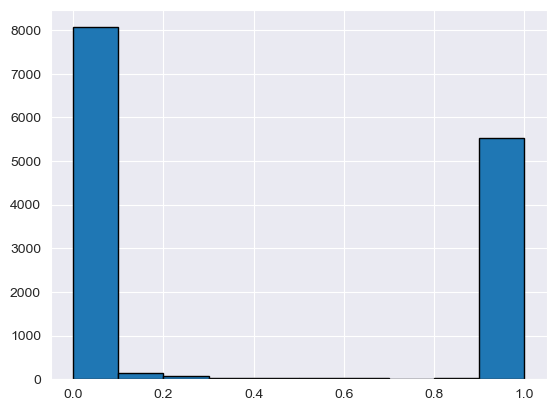

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_proba, bins=10, edgecolor='black')

### Measuring Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
metrics["accuracy"] = accuracy

print(accuracy)

0.9858933046902971


### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[8145,   84],
       [ 113, 5623]])

### Precision, Recall, F1 Score

In [ ]:
import json
from sklearn.metrics import precision_recall_fscore_support

overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["precision"] = overall_metrics[0]
metrics["recall"] = overall_metrics[1]
metrics["f1"] = overall_metrics[2]
metrics["false_positive_rate"] = confusion_matrix(y_test, y_pred)[0, 1] / y_test.value_counts()[
    0]  # Legitimate classified as phishing (Type I error)
metrics["false_negative_rate"] = confusion_matrix(y_test, y_pred)[1, 0] / y_test.value_counts()[
    1]  # Phishing classified as legitimate (Type II error)

print(json.dumps(metrics, indent=4))

{
    "accuracy": 0.9858933046902971,
    "precision": 0.9858911552518851,
    "recall": 0.9858933046902971,
    "f1": 0.9858878359559113,
    "false_positive_rate": 0.01020780167699599,
    "false_negative_rate": 0.019700139470013946
}
